# Majority Voting Experiments

This is the default voting technique used in simple crowdsourcing systems.


## TODO
 * Finish debugging implementation
 * Sort out some of the code duplication.

In [36]:
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io
import os
import random

%matplotlib inline

In [37]:
np.random.seed(0xF00F1E)
random.seed(0xF00F1E)

In [38]:
%run ../crowd/data.py
%run ../crowd/config.py
%run ../crowd/file_util.py
%run ../crowd/graph.py
%run ../crowd/topic.py

## Load data

In [39]:
id_topic_info = load_topic_metadata()
judgements = read_useful_judgement_labels(JUDGEMENT_FILE)
test_data = read_all_test_labels()

In [40]:
len(judgements)

46319

In [41]:
def count_votes(votes):
    relevant_votes = 0
    non_relevant_votes = 0
    for vote in votes:
        if vote.is_relevant > 0:
            relevant_votes += 1
        elif vote.is_relevant == 0:
            non_relevant_votes += 1
        else:
            raise ValueError("Non 0/1 vote.")
    
    return relevant_votes, non_relevant_votes


DEFAULT_BUDGET = 250
COIN_FLIP = "COIN_FLIP"


def get_document_with_least_votes(vote_map):
    # TODO(andrei) Use heap, or even integrate in graph.
    # Sort the map by the values and return the key with the smallest value.
    return (sorted(vote_map.items(), key=lambda i: len(i[1])))[0][0]


def request_vote(topic_judgements, document_id):
    votes = topic_judgements[document_id]
    if len(votes) == 0:
        print("No votes found for document [{}].".format(document_id))
        return None
    
    vote = random.choice(votes)
    return vote

In [42]:
def full_mv_aggregation(document_id, topic_judgements):
    """Compute the voter consensus for the specified document."""
    
    if document_id not in topic_judgements:
        raise ValueError("Document ID#{0} doesn't have any votes to aggregate.".format(document_id))
        
    votes = topic_judgements[document_id]
    rel_votes, non_rel_votes = count_votes(votes)

    if rel_votes == 0 and non_rel_votes == 0:
        raise ValueError("No votes for ground truth document. That's a shame.")
        
    return rel_votes >= non_rel_votes

In [45]:
def evaluate(topic_graph, topic_judgements, ground_truth, vote_aggregation, **kw):
    """ Evaluates a vote aggregation strategy for the specified topic.
    
    Args:
        topic_graph: The document graph of the topic on which we want to
            perform the evaluation.
        topic_judgements: The votes from which we sampled, as a map from
            document ID to a list of 'JudgementRecord's.
        ground_truth: A map of document IDs ground truth 'ExpertJudgement's.
        vote_aggregation: Function used to aggregate a document's votes and
            produce a final judgement.
            
    Returns:
        TODO(andrei) TBD    
        
    Notes:
        TODO(andrei) Consider using loggers to control output verbosity.
        
    """
    iterations = kw['iterations'] if 'iterations' in kw else 10
    budget = kw['budget'] if 'budget' in kw else DEFAULT_BUDGET
    progress_every = kw['progress_every'] if 'progress_every' in kw else 50
    accuracy_every = kw['accuracy_every'] if 'accuracy_every' in kw else 1
    # verbose = kw['verbose'] if 'verbose' in kw else False
        
    print("Performing evaluation of topic [{}].".format(topic_graph.topic))
    print("Aggregation function: [{}]".format(vote_aggregation))
    
    
    all_accuracies = []
#     doc_count = len(votes)
#     print("Performing [{}] vote samples for [{}] total documents."
#           .format(iterations, doc_count))

    for iteration in range(iterations):
        if iteration % progress_every == 0:
                print("Iteration {}/{}.".format(iteration + 1, iterations))

        accuracies = []
        all_accuracies.append(accuracies)
        # The votes we aggregated so far.
        # Don't keep track of anything for which we don't have the ground truth,
        # since there's no way to evaluate that.
        votes = {n.document_id: [] for n in topic_graph.nodes
                 if n.document_id in ground_truth}
                
        for i in range(budget):

            # 1. Pick document (with lowest number of votes)
            document_id = get_document_with_least_votes(votes)
            #print(document_id)

            # 2. Request a vote for that document (sample with replacement)
            vote = request_vote(topic_judgements, document_id)
            votes[document_id].append(vote)

            if i % accuracy_every == 0:
                # 3. Perform the aggregation
                evaluated_judgements = vote_aggregation(topic_graph, votes)

                # 4. Measure accuracy
                accuracy = measure_accuracy(evaluated_judgements, ground_truth, topic_judgements)
                accuracies.append(accuracy)

    return all_accuracies


def aggregate_MV(topic_graph, votes):
    """The default way of aggregating crowdsourcing votes.
    
    Args:
        topic_graph: The current topic's document graph. Not used.
        votes: A map from document ID to a list of sampled 'JudgementRecord's.
        
    Returns:
        A map which contains a boolean relevance for every document.
    """
       
    return {document_id: majority(document_votes)
            for (document_id, document_votes) in votes.items()}
            
    
def majority(votes, tie_handling=COIN_FLIP):
    """Computes the majority of a list of 'JudgementRecord's.
    
    Args:
        votes: A list of 'JudgementRecord' objects.
        tie_handling: An enum specifying how ties are to be treated.
    
    Returns:
        A boolean indicating whether the consensus is "relevant".
        Ties are broken as specified by the 'tie_handling' parameter.
        
    """
    # Note: mind the Nones!
    relevant = len([vote for vote in votes if vote.is_relevant == True])
    non_relevant = len([vote for vote in votes if vote.is_relevant == False])
    
    if relevant > non_relevant:
         return True
    elif relevant < non_relevant:
         return False
    elif tie_handling == COIN_FLIP:
        return random.choice([True, False])
    else:
        raise ValueError("Unknown tie handling technique: [{}]."
                         .format(tie_handling))


def measure_accuracy(evaluated_judgements, ground_truth, topic_judgements):
    # TODO(andrei) Vectorize this computation as much as possible.
    match = 0
    fail = 0
    
    # XXX: this is not meant to be here
    full_match = 0
    full_fail = 0
    
    for doc_id in ground_truth:
        # TODO(andrei) Don't make it this far with shitty data. Filter useless GTs earlier on!
        # Unestabilshed relevance in ground truth.
        if ground_truth[doc_id].label < 0:
            continue
            
        gt_label = (ground_truth[doc_id].label > 0)
        
        total_mean = full_mv_aggregation(doc_id, topic_judgements)
        
        evaluated_label = evaluated_judgements[doc_id]
        if gt_label == evaluated_label:
            match += 1
        else:
            fail += 1
            
        if total_mean == gt_label:
            full_match += 1
        else:
            full_fail += 1
            
#     print("Good: %d / %d" % (match, match + fail))
#     print("Full: Good: %d / %d" % (full_match, full_match + full_fail))

    return match / (match + fail)
        
        
def plot_mv_learning_curve(topic_id):
    topic = id_topic_info[topic_id]
    graph = build_document_graph(topic, FULLTEXT_FOLDER)
    topic_judgements = get_topic_judgements_by_doc_id(topic_id, judgements)
    topic_ground_truth = {truth.document_id: truth for truth in test_data
                          if truth.topic_id == topic_id}
    

    # i.e. up to target_votes votes per doc, on average.
    # TODO(andrei) Make this cleaner and more seamless.
    target_votes = 8
    bud = len(topic_judgements) * target_votes
    acc = evaluate(
        graph,
        topic_judgements,
        topic_ground_truth,
        aggregate_MV,
        budget=bud)

    acc = np.array(acc)
    print(acc.shape)
    acc_avg = np.mean(acc, axis=0)
    print(acc_avg.shape)
        

    plt.plot(np.arange(len(acc_avg)) / len(topic_judgements), acc_avg)
    plt.xlabel("Mean votes per document")
    plt.ylabel("Accuracy")

Built graph with 56 total edges.
Performing evaluation of topic [20996:guillermo venegas lloveras].
Aggregation function: [<function aggregate_MV at 0x10f947ea0>]
Iteration 1/10.
(10, 880)
(880,)


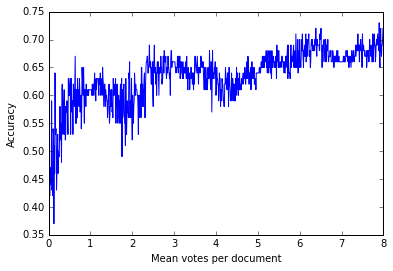

In [49]:
# plot_mv_learning_curve('20910')
plot_mv_learning_curve('20996')
# plot_mv_learning_curve('20686')

In [24]:
len(test_data)

9380

In [26]:
ttest = [t for t in test_data if t.topic_id == '20686']
len(ttest)

115

In [27]:
ttestdocs = [t.document_id for t in ttest]

In [29]:
len(ttestdocs), len(set(ttestdocs))

(115, 115)

In [30]:
trel = [t for t in ttest if t.label > 0]
print(len(trel))

11


In [31]:
tnrel = [t for t in ttest if t.label == 0]
print(len(tnrel))

4


In [32]:
junk = [t for t in ttest if t.label == -1]
print(len(junk))

100


:(